In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:

battles_his = pd.read_csv('./data/battles.csv', sep=',')
pokemons_spec = pd.read_csv('./data/pokemon.csv', sep=',')
battles_his_test = pd.read_csv('./data/q4_test.csv', sep=',')


# Task 1

In [3]:
win_count = battles_his.groupby('Winner').agg( count=pd.NamedAgg(column="Winner", aggfunc="count") ).reset_index().rename(columns={"Winner": "ID"})
occurance = (battles_his.set_index(['First_pokemon','Second_pokemon']).count(level = "First_pokemon")+battles_his.set_index(['First_pokemon','Second_pokemon']).count(level = "Second_pokemon")).reset_index().rename(columns={"First_pokemon": "ID", "Winner": "count"})

In [4]:
temp1 = win_count.loc[win_count['ID'].isin(occurance['ID']),'count'] 
temp2 = occurance.loc[occurance['ID'].isin(win_count['ID']),'count']
occurance.loc[occurance['ID'].isin(win_count['ID']),'count'] = np.asarray(temp1) / np.asarray(temp2)

In [5]:
win_rate = np.asarray(occurance)
win_rate[win_rate[:,1] >1,1] = 0.0

In [6]:
win_list = np.full([len(pokemons_spec)], np.nan)
win_list[win_rate[:,0].astype(int)-1] = win_rate[:,1]


In [7]:
pokemons_spec['Win Rate'] = win_list
pokemons_spec

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,True,False,0.445652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886


# Task 2

In [10]:

from sklearn.model_selection import train_test_split
inbattles_pokes = pokemons_spec.loc[np.logical_not(np.isnan(pokemons_spec['Win Rate']))]
X = np.asarray(inbattles_pokes.iloc[:, 4:10])
y = np.asarray(inbattles_pokes.iloc[:, -1])
cols_name = pokemons_spec.columns.values[4:10]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211)


Variance Score for HP Model : 0.032813471148570805


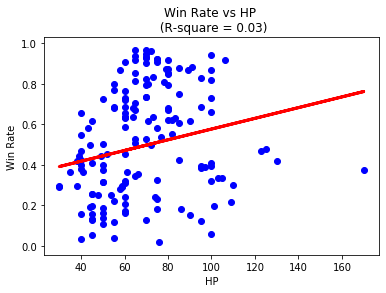

Variance Score for Attack Model : 0.20326769141250867


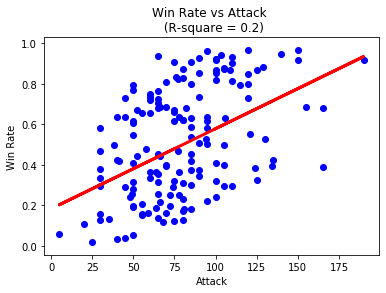

Variance Score for Defense Model : -0.02474153079766994


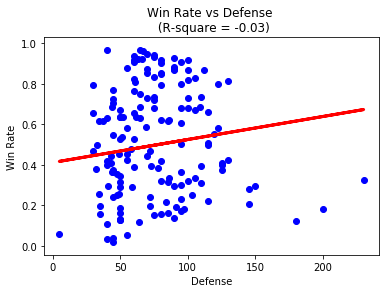

Variance Score for Sp. Atk Model : 0.17616158063066578


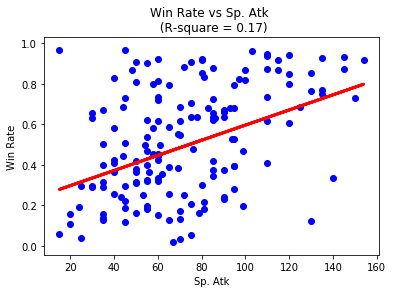

Variance Score for Sp. Def Model : 0.0655048665013841


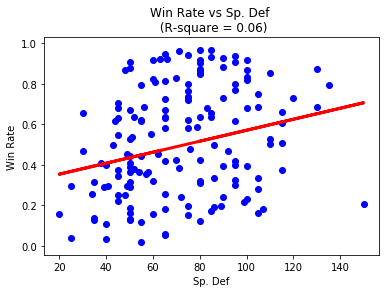

Variance Score for Speed Model : 0.906074305583302


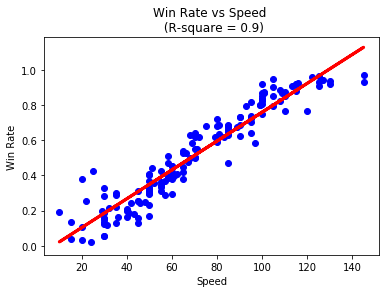

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
linear_models = []
for i in range(6):
    linear_models.append(LinearRegression())
    linear_models[i].fit(X_train[:,i].reshape(-1,1),y_train)
    y_val_pred = linear_models[i].predict(X_val[:,i].reshape(-1,1))
    r2 = r2_score(y_val,y_val_pred)
    print(f'Variance Score for {cols_name[i]} Model : {r2}')
    plt.title(f'Win Rate vs {cols_name[i]} \n (R-square = {math.floor(r2*100)/100})')
    plt.ylabel('Win Rate')
    plt.xlabel(cols_name[i])
    plt.scatter(X_val[:,i], y_val,  color='blue')
    plt.plot(X_val[:,i], y_val_pred, color='red', linewidth=3)
    plt.show()


# Task 3

In [12]:

cols_name = pokemons_spec.columns.values[2:-2]
types = pd.get_dummies(inbattles_pokes['Type 1'], prefix='Type')
types += pd.get_dummies(inbattles_pokes['Type 2'], prefix='Type')
types
inbattles_pokes = pd.concat([inbattles_pokes, types], axis = 1)
inbattles_pokes.drop(['Type 1'], axis = 1, inplace = True)
inbattles_pokes.drop(['Type 2'], axis = 1, inplace = True)




In [18]:
mask = list(inbattles_pokes.columns.values)
mask.remove('#')
mask.remove('Name')
mask.remove('Legendary')
mask.remove('Win Rate')
X = inbattles_pokes.loc[:,mask].astype(int)
y = inbattles_pokes.loc[:, 'Legendary'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211)

In [114]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score
from time import time
eta0s = [1e-2, 1e-3, 1e-4]
learning_decay_modes = ['adaptive', 'constant' , 'invscaling']
random_states = np.random.randint(100, size = 3)
reports = {}
best_eta0 = -1
best_accuracy = -1
best_ldm = None
for ld_mode in learning_decay_modes:
    for eta0 in eta0s:
        times = []
        f1_scores = []
        accuracies = []
        for random_state in random_states:
            start = time()    
            clf_sgd = SGDClassifier(loss='log', max_iter=200, random_state=random_state, verbose=0 , learning_rate= ld_mode, eta0 = eta0) 
            clf_sgd.fit(X_train, y_train)
            report = classification_report(y_val,clf_sgd.predict(X_val))
            accuracy = clf_sgd.score(X_val,y_val)
            times.append(time()-start)
            f1_scores.append(f1_score(y_val,clf_sgd.predict(X_val)))
            accuracies.append(accuracy)
        reports[(ld_mode,eta0)] = (times,f1_scores,accuracies)

for (ld_mode,eta0) in reports:
    print(f"Model with decay mode = {ld_mode} and initial learning rate = {eta0}")
    report = reports[(ld_mode,eta0)]
    std_time = np.std(report[0])
    avg_time = np.mean(report[0])
    std_f1 = np.std(report[1])
    avg_f1 = np.mean(report[1])
    std_acc = np.std(report[2])
    avg_acc = np.mean(report[2])
    print("\tTime: \t\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_time,std_time))
    print("\tF1 Score:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_f1,std_f1))
    print("\tAccuracy:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_acc,std_acc))

        



Model with decay mode = adaptive and initial learning rate = 0.01
	Time: 		0.030(mean)		0.009(sd)
	F1 Score:	0.279(mean)		0.041(sd)
	Accuracy:	0.913(mean)		0.003(sd)
Model with decay mode = adaptive and initial learning rate = 0.001
	Time: 		0.021(mean)		0.005(sd)
	F1 Score:	0.154(mean)		0.000(sd)
	Accuracy:	0.930(mean)		0.000(sd)
Model with decay mode = adaptive and initial learning rate = 0.0001
	Time: 		0.014(mean)		0.003(sd)
	F1 Score:	0.000(mean)		0.000(sd)
	Accuracy:	0.930(mean)		0.000(sd)
Model with decay mode = constant and initial learning rate = 0.01
	Time: 		0.008(mean)		0.002(sd)
	F1 Score:	0.000(mean)		0.000(sd)
	Accuracy:	0.919(mean)		0.008(sd)
Model with decay mode = constant and initial learning rate = 0.001
	Time: 		0.008(mean)		0.002(sd)
	F1 Score:	0.147(mean)		0.110(sd)
	Accuracy:	0.820(mean)		0.091(sd)
Model with decay mode = constant and initial learning rate = 0.0001
	Time: 		0.008(mean)		0.000(sd)
	F1 Score:	0.000(mean)		0.000(sd)
	Accuracy:	0.930(mean)		0.000(sd

In [113]:
from sklearn.neural_network import MLPClassifier
hidden_sizes = [1,2,4,8,16,32,64]
reports.clear()
for hidden_size in hidden_sizes:
    times = []
    f1_scores = []
    accuracies = []
    for random_state in random_states:
            clf_sgd = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=500, random_state=random_state, verbose=0 )
            start = time()  
            clf_sgd.fit(X_train, y_train)
            times.append(time()-start)
            report = classification_report(y_val,clf_sgd.predict(X_val))
            accuracy = clf_sgd.score(X_val,y_val)
            f1_scores.append(f1_score(y_val,clf_sgd.predict(X_val)))
            accuracies.append(accuracy)
    reports[hidden_size] = (times,f1_scores,accuracies)

f1_v_h  = []
acc_v_h = []
for (hidden_size) in reports:
    print(f"Neural Network with 1 hidden-layer of size = {hidden_size}")
    report = reports[(hidden_size)]
    std_time = np.std(report[0])
    avg_time = np.mean(report[0])
    std_f1 = np.std(report[1])
    avg_f1 = np.mean(report[1])
    std_acc = np.std(report[2])
    avg_acc = np.mean(report[2])
    f1_v_h.append([hidden_size,avg_f1])
    acc_v_h.append([hidden_size,avg_acc])
    print("\tTime: \t\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_time,std_time))
    print("\tF1 Score:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_f1,std_f1))
    print("\tAccuracy:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_acc,std_acc))

Neural Network with 1 hidden-layer of size = 1
	Time: 		0.742(mean)		0.118(sd)
	F1 Score:	0.000(mean)		0.000(sd)
	Accuracy:	0.926(mean)		0.006(sd)
Neural Network with 1 hidden-layer of size = 2
	Time: 		0.797(mean)		0.073(sd)
	F1 Score:	0.000(mean)		0.000(sd)
	Accuracy:	0.928(mean)		0.003(sd)
Neural Network with 1 hidden-layer of size = 4
	Time: 		0.807(mean)		0.048(sd)
	F1 Score:	0.205(mean)		0.145(sd)
	Accuracy:	0.938(mean)		0.006(sd)
Neural Network with 1 hidden-layer of size = 8
	Time: 		0.965(mean)		0.072(sd)
	F1 Score:	0.433(mean)		0.223(sd)
	Accuracy:	0.943(mean)		0.014(sd)
Neural Network with 1 hidden-layer of size = 16
	Time: 		1.108(mean)		0.150(sd)
	F1 Score:	0.520(mean)		0.084(sd)
	Accuracy:	0.951(mean)		0.003(sd)
Neural Network with 1 hidden-layer of size = 32
	Time: 		0.907(mean)		0.116(sd)
	F1 Score:	0.644(mean)		0.042(sd)
	Accuracy:	0.955(mean)		0.005(sd)
Neural Network with 1 hidden-layer of size = 64
	Time: 		1.026(mean)		0.359(sd)
	F1 Score:	0.541(mean)		0.021(sd)
	A

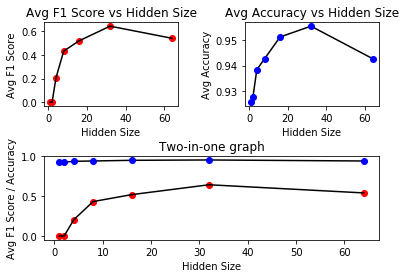

[ 1  2  4  8 16 32 64]


In [63]:

plt.subplot2grid((2, 2), (0, 0))
plt.title(f'Avg F1 Score vs Hidden Size')
plt.ylabel('Avg F1 Score')
plt.xlabel('Hidden Size')
plt.plot(np.asarray(f1_v_h)[:,0].astype(int), np.asarray(f1_v_h)[:,1],  'ro')
plt.plot(np.asarray(f1_v_h)[:,0].astype(int), np.asarray(f1_v_h)[:,1],  color ="black")
plt.subplots_adjust(wspace = 0.5 )
# plt.show()
plt.subplot2grid((2, 2), (0, 1))
plt.title(f'Avg Accuracy vs Hidden Size')
plt.ylabel('Avg Accuracy')
plt.xlabel('Hidden Size')
plt.plot(np.asarray(acc_v_h)[:,0].astype(int), np.asarray(acc_v_h)[:,1], color='black')
plt.plot(np.asarray(acc_v_h)[:,0].astype(int), np.asarray(acc_v_h)[:,1], 'bo')
# plt.show()
plt.subplots_adjust(hspace = 0.6 )
#--------------------------------------------------------------------------------------------
plt.subplot2grid((2, 2), (1, 0),colspan=2)
plt.title(f'Two-in-one graph')
plt.ylabel('Avg F1 Score / Accuracy')
plt.xlabel('Hidden Size')
plt.plot(np.asarray(f1_v_h)[:,0].astype(int), np.asarray(f1_v_h)[:,1],  'ro')
plt.plot(np.asarray(f1_v_h)[:,0].astype(int), np.asarray(f1_v_h)[:,1],  color ="black")

plt.plot(np.asarray(acc_v_h)[:,0].astype(int), np.asarray(acc_v_h)[:,1], color='black')
plt.plot(np.asarray(acc_v_h)[:,0].astype(int), np.asarray(acc_v_h)[:,1], 'bo')

plt.show()

# Task 4 

In [22]:
def isWin(first_poke, winner):
    return (first_poke == winner).astype(int)

battles_his['First Wins'] = isWin(battles_his['First_pokemon'],battles_his['Winner'])
battles_his_test['First Wins'] = isWin(battles_his_test['First_pokemon'],battles_his_test['Winner'])

In [23]:
print(battles_his.head())
print(battles_his_test.head())

First_pokemon  Second_pokemon  Winner  First Wins
0            173             463     463           0
1            174             307     307           0
2            772             181     772           1
3            430             356     430           1
4            519             695     519           1
   First_pokemon  Second_pokemon  Winner  First Wins
0            333              57      57           0
1            541             105     541           1
2            665             687     687           0
3            145             205     205           0
4            598             698     598           1


In [25]:
def rename(spec,num):
    return [f'{x}_{num}' for x in spec]

def id_2_spec(battles_list):
    mask = list(inbattles_pokes.columns.values)
    mask.remove('Name')
    battles_list = pd.merge(battles_list,inbattles_pokes.loc[:,mask].rename(columns = {"#":"First_pokemon"}))
    battles_list.rename(columns=dict(zip(mask, rename(mask,1))), inplace= True)
    battles_list = pd.merge(battles_list,inbattles_pokes.loc[:,mask].rename(columns = {"#":"Second_pokemon"}))
    battles_list.rename(columns=dict(zip(mask, rename(mask,2))), inplace= True)
    return battles_list

train_val_set = id_2_spec(battles_his.copy()).iloc[:,3:]
test_set = id_2_spec(battles_his_test.copy()).iloc[:,3:]
X_train_val, y_train_val = train_val_set.iloc[:,1:].astype(int), train_val_set.iloc[:,0]
X_test, y_test = test_set.iloc[:,1:].astype(int), test_set.iloc[:,0]

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter = 10)
grid_dic = {   'hidden_layer_sizes': [(8, ), (16, ), (32,)],
               'solver': ['sgd', 'adam'],
               'activation': ['tanh', 'relu'],
               
             }
scores = {'F1_score':make_scorer(f1_score),'Accuracy':make_scorer(f1_score) }
grid_search = GridSearchCV(mlp,grid_dic, cv=5, scoring=scores, refit='Accuracy', verbose = 2)
grid_search.get_params()
grid_search.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] activation=tanh, hidden_layer_sizes=(8,), solver=sgd ............
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  activation=tanh, hidden_layer_sizes=(8,), solver=sgd, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(8,), solver=sgd ............
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV]  activation=tanh, hidden_layer_sizes=(8,), solver=sgd, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(8,), solver=sgd ............
[CV]  activation=tanh, hidden_layer_sizes=(8,), solver=sgd, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(8,), solver=sgd ............
[CV]  activation=tanh, hidden_layer_sizes=(8,), solver=sgd, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(8,), solver=sgd ............
[CV]  activation=tanh, hidden_layer_sizes=(8,), solver=sgd, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(8,), solver

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=10, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['

In [116]:
from sklearn.metrics import make_scorer,accuracy_score
avg_acc = grid_search.cv_results_['mean_test_Accuracy']
std_acc = grid_search.cv_results_['std_test_Accuracy']
avg_f1 = grid_search.cv_results_['mean_test_F1_score']
std_f1 = grid_search.cv_results_['std_test_F1_score']
avg_time = grid_search.cv_results_['mean_fit_time']
std_time = grid_search.cv_results_['std_fit_time']
for i,param  in enumerate(grid_search.cv_results_['params']):
    print(param)
    print("\tTime: \t\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_time[i],std_time[i]))
    print("\tF1 Score:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_f1[i],std_f1[i]))
    print("\tAccuracy:\t{0:.3f}(mean)\t\t{1:.3f}(sd)".format(avg_acc[i],std_acc[i]))

{'activation': 'tanh', 'hidden_layer_sizes': (8,), 'solver': 'sgd'}
	Time: 		0.871(mean)		0.095(sd)
	F1 Score:	0.913(mean)		0.015(sd)
	Accuracy:	0.913(mean)		0.015(sd)
{'activation': 'tanh', 'hidden_layer_sizes': (8,), 'solver': 'adam'}
	Time: 		0.860(mean)		0.050(sd)
	F1 Score:	0.930(mean)		0.005(sd)
	Accuracy:	0.930(mean)		0.005(sd)
{'activation': 'tanh', 'hidden_layer_sizes': (16,), 'solver': 'sgd'}
	Time: 		0.831(mean)		0.028(sd)
	F1 Score:	0.929(mean)		0.005(sd)
	Accuracy:	0.929(mean)		0.005(sd)
{'activation': 'tanh', 'hidden_layer_sizes': (16,), 'solver': 'adam'}
	Time: 		0.950(mean)		0.053(sd)
	F1 Score:	0.927(mean)		0.003(sd)
	Accuracy:	0.927(mean)		0.003(sd)
{'activation': 'tanh', 'hidden_layer_sizes': (32,), 'solver': 'sgd'}
	Time: 		1.051(mean)		0.029(sd)
	F1 Score:	0.927(mean)		0.008(sd)
	Accuracy:	0.927(mean)		0.008(sd)
{'activation': 'tanh', 'hidden_layer_sizes': (32,), 'solver': 'adam'}
	Time: 		1.243(mean)		0.145(sd)
	F1 Score:	0.930(mean)		0.007(sd)
	Accuracy:	0.930(me

In [117]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_Accuracy'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_Accuracy'][candidate],
                          results['std_test_Accuracy'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.930 (std: 0.007)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (32,), 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.930 (std: 0.005)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (8,), 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.929 (std: 0.005)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (16,), 'solver': 'sgd'}



In [120]:
test_acc = grid_search.best_estimator_.score(X_test,y_test)
print(f"The accuracy of the test set prediction from the Best Model: {test_acc}")
print(grid_search.best_estimator_)

The accuracy of the test set prediction from the Best Model: 0.94
MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


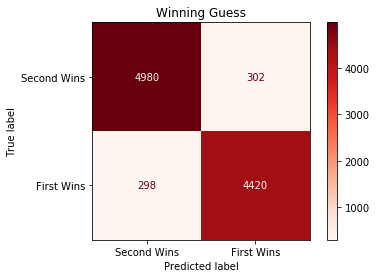

In [119]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                             display_labels=['Second Wins', 'First Wins'],
                             cmap=plt.cm.Reds,
                             values_format='.5g')
disp.ax_.set_title('Winning Guess')
plt.show()